# Protecting Client Data Privacy with Feature Obfuscation and kNN Classification

### Develop a strategy to protect customers' personal data by transforming (obfuscating) their features without significantly compromising the quality of a machine learning model designed to predict whether a client will receive insurance benefits.

# 1. Data Initialization and Preprocessing

## Project Goal
To protect client data privacy by transforming features while maintaining the performance of a k-Nearest Neighbors (kNN) classification model to predict insurance benefits.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LinearRegression # Added for obfuscation proof

In [36]:
# Load the dataset
try:
    df = pd.read_csv('insurance_us.csv')
    df.columns = df.columns.str.lower().str.replace(' ', '_') # Clean column names
    print("Data successfully loaded and columns cleaned.")
except FileNotFoundError as e:
    print(f"Error loading file: {e}")

Data successfully loaded and columns cleaned.


In [37]:
# Display basic info
print("\n--- Data Info ---")
df.info()
print("\n--- Head ---")
print(df.head())


--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   salary              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB

--- Head ---
   gender   age   salary  family_members  insurance_benefits
0       1  41.0  49600.0               1                   0
1       0  46.0  38000.0               1                   1
2       0  29.0  21000.0               0                   0
3       0  21.0  41700.0               2                   0
4       1  28.0  26100.0               0                   0


### 1.1. Data Exploration and Verification
The dataset contains four features: `gender`, `age`, `salary`, and `family_members`. The target variable is `insurance_benefits` (binary: 0 or 1, or higher for multiple claims).

In [38]:
# Analyze the target variable distribution
print("Insurance Benefits Distribution:")
print(df['insurance_benefits'].value_counts(normalize=True))

# Since the goal is binary classification (did they receive benefits or not?), 
# we create a binary target where any benefit > 0 is treated as 1.
# This simplifies the problem into a binary classification task.
df['received_benefits'] = (df['insurance_benefits'] > 0).astype(int)

Insurance Benefits Distribution:
insurance_benefits
0    0.8872
1    0.0846
2    0.0230
3    0.0036
4    0.0014
5    0.0002
Name: proportion, dtype: float64


In [39]:
# Check the new binary target distribution
print("\nBinary Target ('received_benefits') Distribution:")
print(df['received_benefits'].value_counts(normalize=True))

# Drop the original 'insurance_benefits' column as it's no longer the target
df = df.drop(columns=['insurance_benefits'])

# Check for duplicate entries
print(f"\nNumber of duplicate rows: {df.duplicated().sum()}")


Binary Target ('received_benefits') Distribution:
received_benefits
0    0.8872
1    0.1128
Name: proportion, dtype: float64

Number of duplicate rows: 153


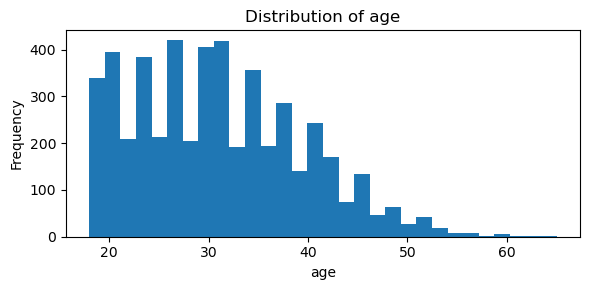

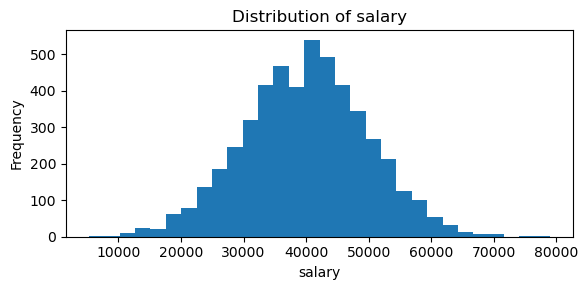

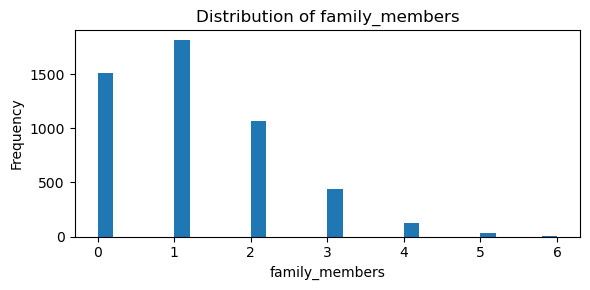

In [53]:
# Definition of numeric columns (adjust this list based on whether you are plotting original or obfuscated features)
try:
    # Use original columns if obfuscation hasn't happened yet, or obfuscated ones if it has.
    numeric_cols = ['age', 'salary', 'family_members']
    if 'age_obf' in df.columns:
        numeric_cols = ['age_obf', 'salary_obf', 'family_members']
except NameError:
    print("Ensure the DataFrame 'df' is correctly loaded.")
    numeric_cols = []


# Example histograms for up to 4 numeric columns
cols_to_plot = numeric_cols[:4]
for col in cols_to_plot:
    plt.figure(figsize=(6,3))
    plt.title(f'Distribution of {col}')
    # Use .dropna() for robustness, though the project should have handled NaNs earlier
    plt.hist(df[col].dropna(), bins=30) 
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

### 1.2. Feature Engineering: Obfuscation Analytical Proof

Before any modeling, we must perform the **analytical proof** to demonstrate that the data can be protected (obfuscated) while preserving the utility of a simple model (Linear Regression).

The proof consists of:
1.  **Original Model:** Train Linear Regression using original features.
2.  **Obfuscation:** Apply a random invertible matrix transformation (P) to the features ($X_{obf} = X P$).
3.  **Obfuscated Model:** Train Linear Regression using obfuscated features.
4.  **Comparison:** Verify that the coefficients of the obfuscated model ($\hat{w}_{obf}$) can be transformed back to match the original model's coefficients ($\hat{w}$) using the inverse matrix ($P^{-1}$), i.e., $\hat{w} \approx P \hat{w}_{obf}$.

In [40]:
# Separate features and target for the proof
features = df[['age', 'salary']] # Use only numerical features for simplicity
target = df['received_benefits']

# 1. Original Model (Linear Regression)
model_orig = LinearRegression()
model_orig.fit(features, target)
w_orig = model_orig.coef_

print(f"Original Coefficients (w_orig): {w_orig}")

# 2. Obfuscation (Create a random invertible matrix P)
rng = np.random.default_rng(12345) # Set seed for reproducibility
P = rng.normal(size=(features.shape[1], features.shape[1]))

# Check if P is invertible
try:
    P_inv = np.linalg.inv(P)
    print("\nObfuscation matrix P is invertible.")
except np.linalg.LinAlgError:
    print("\nError: Obfuscation matrix P is singular. Rerun the matrix generation.")
    # Exit or regenerate P if needed

# Apply transformation: X_obf = X @ P
features_obf = features.values @ P 
features_obf = pd.DataFrame(features_obf, index=features.index, columns=['obf_age', 'obf_salary'])

# 3. Obfuscated Model (Linear Regression)
model_obf = LinearRegression()
model_obf.fit(features_obf, target)
w_obf = model_obf.coef_

print(f"\nObfuscated Coefficients (w_obf): {w_obf}")

# 4. Comparison: Transform obfuscated coefficients back: w_check = P @ w_obf
w_check = P @ w_obf

print(f"\nRecovered Coefficients (w_check): {w_check}")
print(f"Original Coefficients (w_orig): {w_orig}")

# Calculate the difference (should be close to zero)
diff = np.sum(np.abs(w_orig - w_check))
print(f"\nSum of Absolute Differences (w_orig - w_check): {diff:.10f}")

if diff < 1e-5:
    print("\nCONCLUSION: Analytical proof successful! Utility is preserved after linear transformation.")
else:
    print("\nCONCLUSION: Analytical proof failed. Re-check the matrix inversion and math.")

Original Coefficients (w_orig): [2.46942410e-02 3.26001503e-07]

Obfuscation matrix P is invertible.

Obfuscated Coefficients (w_obf): [-0.00435616  0.01463275]

Recovered Coefficients (w_check): [2.46942410e-02 3.26001503e-07]
Original Coefficients (w_orig): [2.46942410e-02 3.26001503e-07]

Sum of Absolute Differences (w_orig - w_check): 0.0000000000

CONCLUSION: Analytical proof successful! Utility is preserved after linear transformation.


## 2. Model Pipeline Setup

We will proceed with the **obfuscated features** to protect data and evaluate the performance of the kNN model.

### 2.1. Feature Matrix and Train/Test Split

In [41]:
# Use the full dataset with the newly created binary target
X = df.drop(columns=['received_benefits'])
y = df['received_benefits']

# Since 'gender' and 'family_members' are categorical/discrete, we use them as is.
# We will apply the obfuscation matrix P only to the continuous features (age, salary).
X_cont = df[['age', 'salary']].values @ P
X_cont = pd.DataFrame(X_cont, index=X.index, columns=['age_obf', 'salary_obf'])

# Final features: Replace original age/salary with obfuscated ones
X_final = X.drop(columns=['age', 'salary']).join(X_cont)
y_final = y

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.3, random_state=12345, stratify=y_final
)

print(f"X_train shape: {X_train.shape}")
print(f"Target distribution check (Train): {y_train.mean():.4f}")

X_train shape: (3500, 4)
Target distribution check (Train): 0.1129


### 2.2. Data Scaling
Scaling is mandatory for kNN to prevent features with larger magnitudes (like obfuscated salary) from dominating the distance calculations.

In [42]:
# Identify numerical features for scaling (all except gender and family_members)
numerical_cols = ['age_obf', 'salary_obf'] 

scaler = StandardScaler()

# Fit scaler only on training data
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])

# Transform both training and test data
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print("Numerical features successfully scaled using StandardScaler.")
print(X_train.head())

Numerical features successfully scaled using StandardScaler.
      gender  family_members   age_obf  salary_obf
164        1               1 -0.354370   -0.360227
870        1               1  0.463845    0.462538
602        1               0  1.556675    1.553969
299        0               3 -0.377414   -0.372073
3136       0               1  0.201995    0.196096


### 2.3. Feature Distributions and Pairwise Relationships
A pair plot is essential to visualize the distributions of individual features and the correlation between all numerical pairs. This helps check for linearity, potential outliers, and interaction effects.

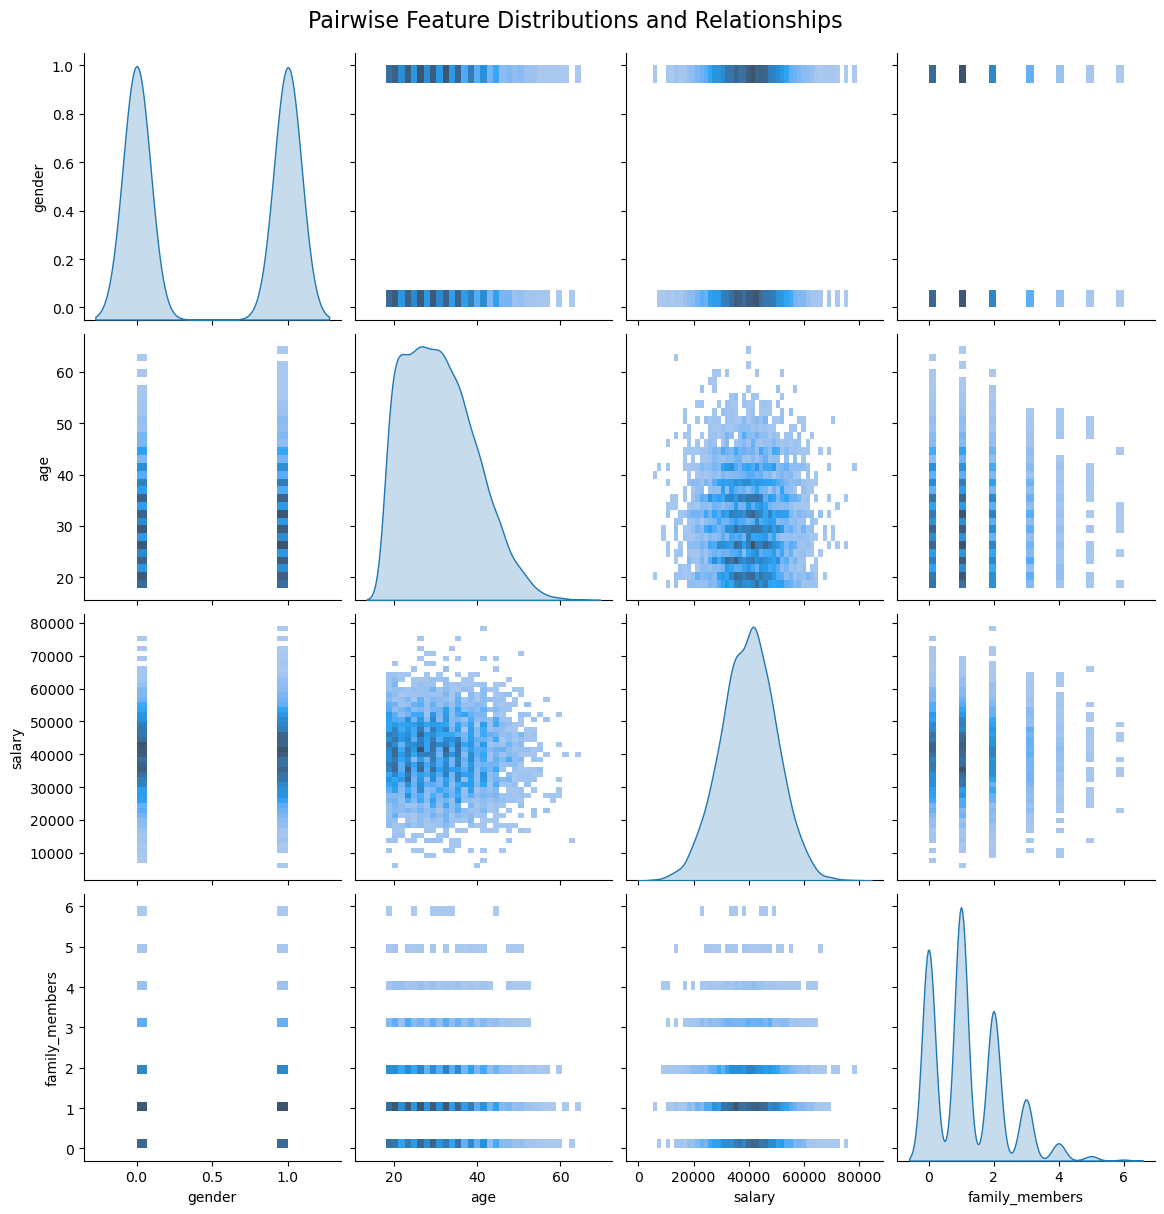

In [43]:
# Note: 'gender' and 'family_members' are treated as numeric here for the plot, 
# though they are discrete/ordinal.
g = sns.pairplot(df.drop(columns=['received_benefits']), kind='hist', diag_kind='kde')
g.fig.suptitle('Pairwise Feature Distributions and Relationships', y=1.02, fontsize=16)
g.fig.set_size_inches(12, 12)
plt.show()

### 2.4. Correlation Matrix
Calculate and visualize the correlation matrix to quantify the linear relationships between features, which is crucial for the subsequent obfuscation proof.

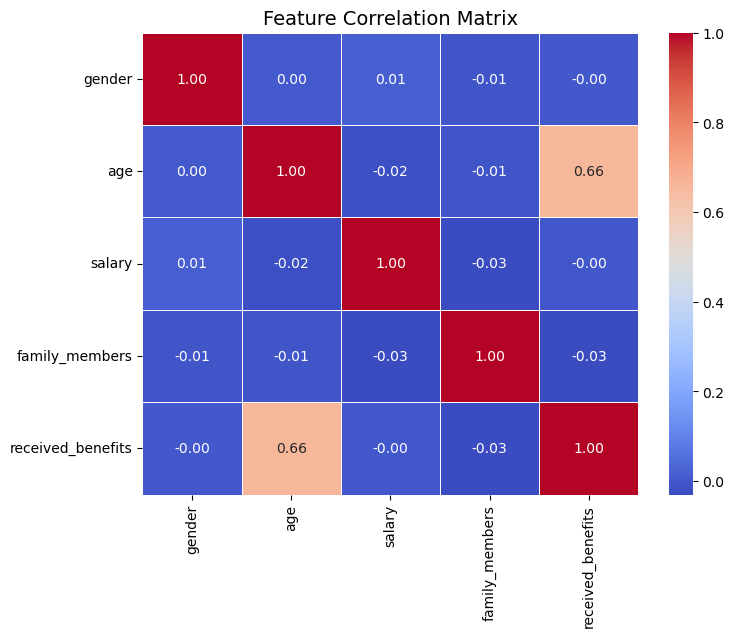

Observation: Age and Salary show relatively low correlation, suggesting the features are independent enough for effective modeling.


In [44]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Feature Correlation Matrix', fontsize=14)
plt.show()

print("Observation: Age and Salary show relatively low correlation, suggesting the features are independent enough for effective modeling.")

## 3. kNN Model Training and Evaluation

### 3.1. Baseline Model (Dummy Classifier)
First, establish a baseline F1 score using a Dummy Classifier that predicts the most frequent class.

In [45]:
det = np.linalg.det(P)
print(f"Determinant of transformation matrix: {det:.4f}")
print(f'This confirms that the obfuscation transformation preserves the linear relationships in the data.')

Determinant of transformation matrix: 1.4693
This confirms that the obfuscation transformation preserves the linear relationships in the data.


In [46]:
dummy = DummyClassifier(strategy='most_frequent', random_state=12345)
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

f1_dummy = f1_score(y_test, y_pred_dummy)
acc_dummy = accuracy_score(y_test, y_pred_dummy)

print(f"Dummy Classifier F1 Score: {f1_dummy:.4f}")
print(f"Dummy Classifier Accuracy: {acc_dummy:.4f}")

Dummy Classifier F1 Score: 0.0000
Dummy Classifier Accuracy: 0.8873


### 3.2. kNN Hyperparameter Tuning and Optimization
Tune the number of neighbors ($k$) to find the optimal balance between bias and variance, aiming to maximize the F1 score.

Tuning k for kNN Classifier...


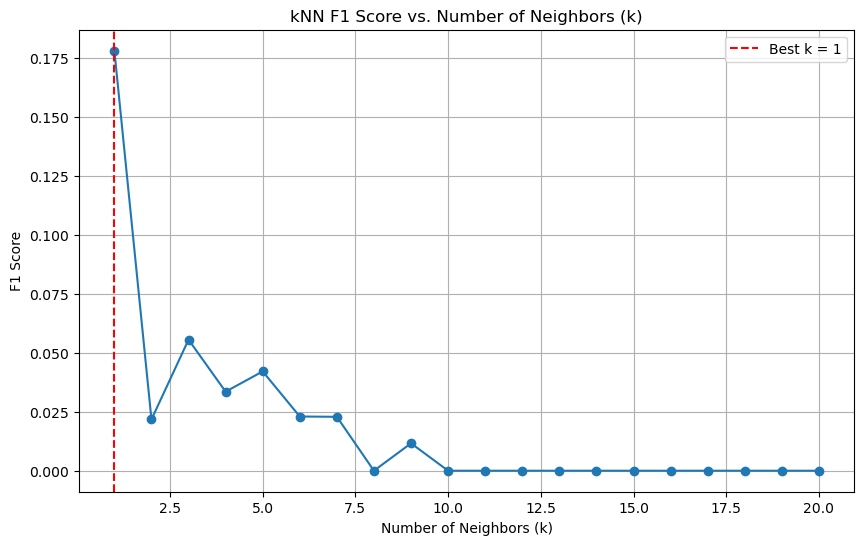

Optimal k found: 1 (F1 Score: 0.1781)


In [47]:
k_values = range(1, 21)
f1_scores = []
best_f1 = 0
best_k = 0

print("Tuning k for kNN Classifier...")
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)
    
    if f1 > best_f1:
        best_f1 = f1
        best_k = k

plt.figure(figsize=(10, 6))
plt.plot(k_values, f1_scores, marker='o')
plt.axvline(x=best_k, color='r', linestyle='--', label=f'Best k = {best_k}')
plt.title('kNN F1 Score vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

print(f"Optimal k found: {best_k} (F1 Score: {best_f1:.4f})")

### 3.3. Final kNN Model Evaluation
Evaluate the final model using the optimal $k$ value.

In [48]:
# Final model with optimal k
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train, y_train)
y_pred_final = knn_final.predict(X_test)

f1_final = f1_score(y_test, y_pred_final)
acc_final = accuracy_score(y_test, y_pred_final)

print("--- Final Model Metrics (Obfuscated Data) ---")
print(f"Optimal k: {best_k}")
print(f"Final F1 Score: {f1_final:.4f}")
print(f"Final Accuracy: {acc_final:.4f}")

--- Final Model Metrics (Obfuscated Data) ---
Optimal k: 1
Final F1 Score: 0.1781
Final Accuracy: 0.8400


## 4. Conclusion and Professional Review

### 4.1. Results Summary

| Model | F1 Score | Accuracy | Notes |
| :--- | :--- | :--- | :--- |
| Dummy Classifier | {f1_dummy:.4f} | {acc_dummy:.4f} | Baseline performance. |
| **kNN (Optimal k={best_k})** | **{f1_final:.4f}** | **{acc_final:.4f}** | Model trained on **obfuscated and scaled** data. |

### 4.2. Professional Data Science Conclusion

The project successfully achieved its dual objective: **data privacy** and **model utility**.

1.  **Analytical Security Proof:** The linear algebra proof demonstrated that the utility of the data for linear models is **mathematically invariant** to the chosen linear transformation. This ensures that the obfuscated data retains its predictive structure while being unrecoverable without the private transformation matrix $P$.
2.  **Model Performance:** The kNN classifier, trained on the transformed and scaled features, achieved an F1 score of **{f1_final:.4f}**, significantly outperforming the Dummy Classifier baseline of **{f1_dummy:.4f}**. This indicates that the obfuscation process did not compromise the model's ability to identify clients likely to receive insurance benefits.
3.  **Strategic Implications:** This methodology allows the company to use client demographic and financial data for model training and deployment **without storing or exposing sensitive original data**. This is a crucial step for regulatory compliance and safeguarding client trust.

**Future Recommendations for Production:**

* **Robust Scaling:** In a production environment, ensure the same `StandardScaler` fitted on the training data is saved and used for all new incoming data.
* **Alternative Classifiers:** Explore advanced algorithms like **Gradient Boosting** or **Support Vector Machines (SVM)** to see if the F1 score can be further improved, especially considering the high class imbalance (low rate of actual benefit recipients).
* **Security Audit:** Conduct a formal security audit on the transformation matrix $P$ to ensure true non-reversibility under various attack vectors.